# ASAS-SN-J06000 Light Curve Analysis

M Kenworthy kenworthy@strw.leidenuniv.nl // Leiden Observatory

2019 Dec 26

Astronomers telegram http://www.astronomerstelegram.org/?read=13346 reports an unusual dimming star ASASSN-V J060000.76-310027.83.

No dimming for 2200 days, then it is dipping with increasing drop over 0.25 mags over 1 day.

Eric Mamajek tweet on it: https://twitter.com/EricMamajek/status/1205229364037570561

This looks like a completely normal, negligibly reddened ~K5.5 dwarf. Low velocity and spot on solar main sequence => thin disk. 3D velocity no where near nearby very young clusters/associations, so unlikely to be <100 Myr. #GaiaDR2 Teff and luminosity appear to be spot on.


ASASSN-V J060000.76-310027.83 (position from Gaia DR2, source_id=2891196718939580672, d=156 pc, L=0.14 L_sun, T_eff=4270 K)

In [1]:
import numpy as np
from astropy import constants as c
from astropy import units as u
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

@u.quantity_input
def atoP(a:u.au, m1:u.M_sun, m2:u.M_jup)->u.year:
    """
    Calculate period from orbital radius and masses

    Args:
        a: semi-major axis
        m1, m2: Primary and secondary masses

    Returns:
        P: orbital period

    >>> import astropy.units as u
    >>> atoP(1.*u.au, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 0.99954192 yr>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)

    const = c.G/(4.*np.pi*np.pi)

    mu = m1 + m2

    P2 = np.power(a,3.)/(const*mu)

    P = np.power(P2, 0.5)
    return P

@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = P*P*const*mu
    aa = np.power(a3, 1./3.)
    
    return aa

@u.quantity_input
def rhill(m1: u.Msun, m2: u.Mjup, a: u.au)->u.au:
    """
    Hill radius of the secondary m2 orbiting around m1
    
    Args:
        m1, m2: primary and secondary masses
        a: distance between m1 and m2

    Returns:
        rhill: radius of Hill sphere of m2

    >>> import astropy.units as u
    >>> rhill(1.0 * u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 0.35489325 AU>
    """

    mu = m2 / (m1 + m2)
    rh = a * np.power(mu/3., 1./3.)
    return rh

## Read in all g data



In [2]:
# aavso
from astropy.io import ascii
import matplotlib
aavso_file = 'data/aavso/aavsodata_5e1c837fa4dc4.txt'
ta = ascii.read(aavso_file)

from astropy.time import Time

# read in JD into a Time object for easy conversion

ta['MJD'] = ta['JD'] - 2400000.5

times = Time(ta['JD'], format='jd')

from datetime import datetime

now = Time(datetime.utcnow(),format='datetime')

print('current MJD is {}'.format(now.mjd))

current MJD is 58862.53649074615


In [3]:

#ta.show_in_notebook()

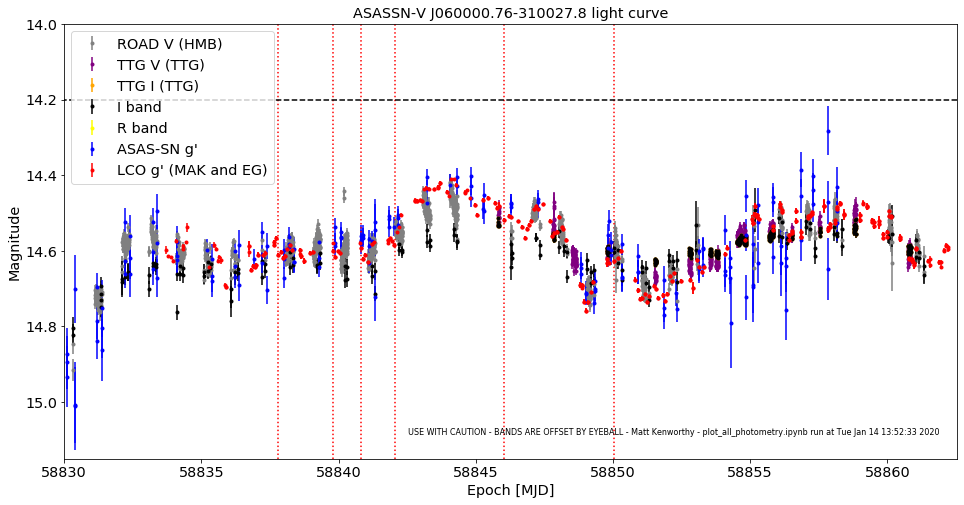

In [4]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)

import os, sys
import datetime

tsac = ascii.read('data/lco/lco_gsa.ecsv')

tsac['dmag'] = 2.5 * np.log10(tsac['relfluxT1n'])
tsac['dmagerr'] = 2.5 * np.log10(tsac['relfluxT1nerr'])

tasas = ascii.read('data/asassn/asas.ecsv')

tasas['mag'] = tasas['mag'].astype(float)
mask = (tasas['Filter'] == 'g') & (tasas['mag'] < 20) 
#mask = (tasas['mag'] < 20) 

tasasv = tasas[mask]

# HMB flux
tamask = (ta['Band']=='V') & (ta['Observer Code']=='HMB')
tap = ta[tamask]
plt.errorbar(tap['MJD'],tap['Magnitude']+0.64, yerr=tap['Uncertainty'], fmt='.', color='gray', label="ROAD V (HMB)")



# TTG flux
tamask = (ta['Band']=='V') & (ta['Observer Code']=='TTG')
tap = ta[tamask]
plt.errorbar(tap['MJD'],tap['Magnitude']+0.73, yerr=tap['Uncertainty'], fmt='.', color='purple', label="TTG V (TTG)")

# TTG flux
tamask = (ta['Band']=='I') & (ta['Observer Code']=='TTG')
tap = ta[tamask]
plt.errorbar(tap['MJD'],tap['Magnitude']+2.2, yerr=tap['Uncertainty'], fmt='.', color='orange', label="TTG I (TTG)")

# I flux
tamask = (ta['Band']=='I')
tap = ta[tamask]
plt.errorbar(tap['MJD'],tap['Magnitude']+2.2, yerr=tap['Uncertainty'], fmt='.', color='black', label="I band")

# R flux
tamask = (ta['Band']=='R')
tap = ta[tamask]
plt.errorbar(tap['MJD'],tap['Magnitude']+2.2, yerr=tap['Uncertainty'], fmt='.', color='yellow', label="R band")

# HMB I flux
tamask = (ta['Band']=='I') & (ta['Observer Code']=='HMB')
tap = ta[tamask]
#plt.errorbar(tap['MJD'],tap['Magnitude']+2.15, yerr=tap['Uncertainty'], fmt='.', color='green', label="ROAD I (HMB)")


plt.errorbar(tasasv['MJD'],tasasv['mag'], yerr=tasasv['mag_err'], fmt='.',color='blue', label="ASAS-SN g'")

# LCO data

tlco = ascii.read('data/lco/lco.ecsv')
plt.errorbar(tlco['MJD'],tlco['gmag']+13.05, yerr=tlco['gmag_err'], fmt='.',color='red', label="LCO g' (MAK and EG)")

# SALT spectroscopc observations [HD to MJD]

salt_epoch = np.array([2458838.307512, 2458840.30739, 2458841.30588, 2458842.548183, 2458846.531863, 2458850.525301]) - 2400000.5

plt.xlim(58830, now.mjd)
plt.ylim(15.15,14.00)

plt.vlines(salt_epoch, 15.15,14.00, linestyle='dotted', color='red')

# decorate the plot

plt.ylabel('Magnitude')
plt.xlabel('Epoch [MJD]')
plt.title('ASASSN-V J060000.76-310027.8 light curve')
plt.legend()

# normal flux level

plt.hlines(14.2, 50000, now.mjd, linestyle='dashed')

# tagline

runtime = "USE WITH CAUTION - BANDS ARE OFFSET BY EYEBALL - Matt Kenworthy - plot_all_photometry.ipynb run at " + datetime.datetime.now().strftime("%c")
tyb = dict(color='black', fontsize=8)
ax.text(0.98, 0.05, runtime, ha='right', va='bottom', transform=ax.transAxes, **tyb)

out = 'ASASSNV_J0600_{:.1f}.pdf'.format(now.mjd)
plt.savefig(out,bbox_inches='tight')

In [5]:
#tlco.show_in_notebook()

## multipanel plot

Now making a single page with one panel per band.

The data tables are:

tlco = LCO observations by M Kenworthy and E Gomez

ta = AAVSO data (multiple observers)

tasas = ASAS-SN data (long baseline, lots of data)



In [6]:
tasp = ascii.read('data/asassn/wd_lc.csv')
tasp['MJD'] = tasp['HJD']-2400000.5

# get a list of the unique bandpasses
ta_by_band = ta.group_by('Band')
print('all bands in the AAVSO table:')
print(ta_by_band.groups.keys)

# get list of unique observers from AAVSO
ta_by_observer = ta.group_by('Observer Code')

print('all observers in the AAVSO table')
print(ta_by_observer.groups.keys)

#tasp.show_in_notebook()

all bands in the AAVSO table:
Band
----
   B
   I
   R
   V
all observers in the AAVSO table
Observer Code
-------------
          DFS
          HMB
          TTG


In [7]:

tsac = ascii.read('data/lco/lco_gsa.ecsv')

tsac['dmag'] = 2.5 * np.log10(tsac['relfluxT1n'])
tsac['dmagerr'] = 2.5 * np.log10(tsac['relfluxT1nerr'])
tsac['dmagerr'] = 0.01

#tsac.show_in_notebook()

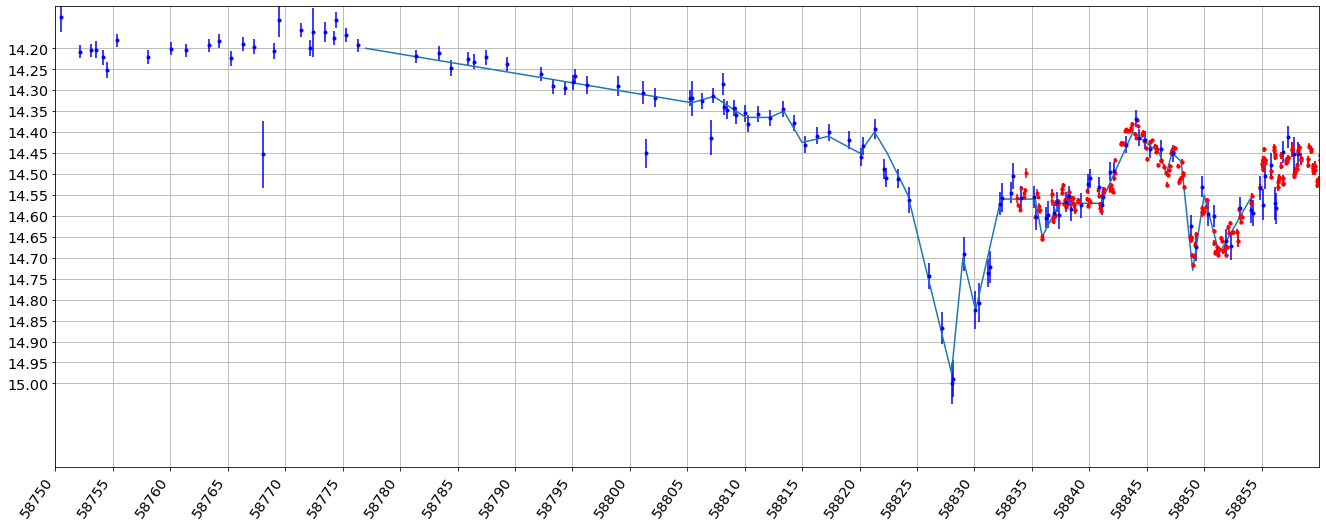

In [8]:
%matplotlib inline

fig, axes = plt.subplots(1, 1, figsize=(26, 8)) # , sharey=True)
axes.errorbar(tlco['MJD'],tlco['gmag']+13.01, yerr=tlco['gmag_err'], fmt='.',color='red', label="LCO g' (MAK and EG)")
axes.errorbar(tasp['MJD'], tasp['mag'], yerr=tasp['mag_err'], fmt='.', color='blue', label='ASAS-SN PSF sub')

axes.set_yticks(np.arange(14.2, 15.0, step=0.05))
axes.set_xticks(np.arange(58700, 58860, step=5))
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for tick in axes.get_xticklabels():
            tick.set_rotation(55)
            tick.set_ha('right')
            
c = ascii.read('g_band_straight_lines.txt')
axes.plot(c['MJD'],c['g'])
axes.set_xlim(58750,58860)

axes.set_ylim(15.2,14.1)

plt.grid()
plt.savefig('grid_g_curve.pdf')

current band is B
current band is g
current band is V
current band is R
current band is I


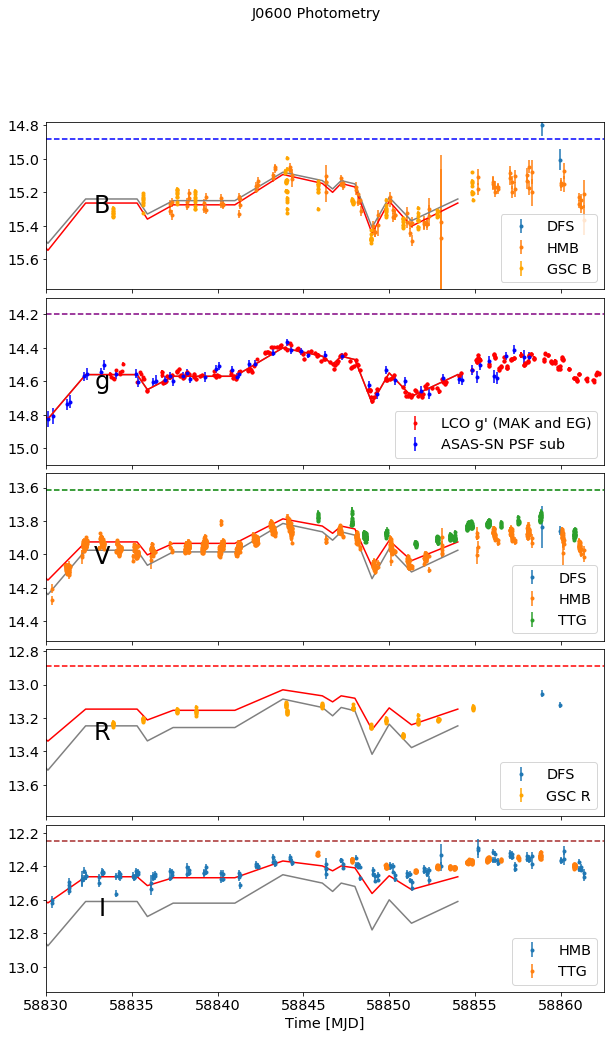

In [9]:
%matplotlib inline

from astropy.table import * 

from datetime import datetime
now = Time(datetime.utcnow(),format='datetime')

mybands = ('B','g','V','R','I') # ordered bands to plot

#mybands = ('B','V','R','I','g') # ordered bands to plot

mag0 = {'g':14.2, 'B':14.88, 'V':13.615, 'R':12.887, 'I':12.25}

# BV from APASS on EEM recommendation
# https://vizier.u-strasbg.fr/viz-bin/VizieR-5?-ref=VIZ5e10875b76c7&-out.add=.&-source=II/336/apass9&-c=090.003102%20-31.007798,eq=J2000,rs=2&-out.orig=o

# BV from UCAC4 
# https://vizier.u-strasbg.fr/viz-bin/VizieR-5?-ref=VIZ5e0fb8ce38d6&-out.add=.&-source=I/322A/out&UCAC4===295-008865&-out.orig=o

# g and V from ASAS-SN eyeballing

band_wlen = {'g':475, 'B':445, 'V':551, 'R':658, 'I':806}
band_color = {'g':'purple', 'B':'blue', 'V':'green', 'R':'red', 'I':'brown'}

n_bands = len(mybands)

t_min = 58830
t_max = now.mjd

fig, axes = plt.subplots(n_bands, 1, figsize=(10, 16), sharex=True) # , sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# g': Effective central wavelength 475.4nm, FWHM 138.7nm from https://www.aip.de/en/research/facilities/stella/instruments/data/sloanugriz-filter-curves

gtable = Table(data=None)

# other filters taken from https://en.wikipedia.org/wiki/Photometric_system
# B	445 nm	94 nm	b	"B" stands for blue.
# V	551 nm	88 nm	v, v'	"V" stands for visual.
# G[3]	464 nm	128 nm	g'	"G" stands for green.
# R	658 nm	138 nm	r, r', R', Rc, Re, Rj	"R" stands for red.
# I	806 nm	149 nm	i, i', Ic, Ie, Ij	"I" stands for infrared.

for (ax, band) in zip(axes, mybands): # loop through all the bands we want to plot
        print('current band is {}'.format(band))
        # photometric band label
        ax.text(0.1, 0.5, band[0], ha='center', va='center', fontsize=24, transform=ax.transAxes)
        
        ax.hlines(mag0[band], t_min, t_max, linestyle='dashed', color=band_color[band])

        # AAVSO table
        # we are plotting 'band' so let's get all the observers who have observed in that band
        ta_currentband = ta[ta['Band']==band]
        #print('total number of measurements in {} band is {}'.format(band, len(ta_currentband)))
        
        if len(ta_currentband)>0:
            # get unique names of all observers for that currentband
            ta_currentband_by_obs = ta_currentband.group_by('Observer Code').groups.keys
            
            for currobs in ta_currentband_by_obs:
                mask = (ta['Band']==band) & (ta['Observer Code']==currobs[0])
                t = ta[mask]
                ax.errorbar(t['MJD'],t['Magnitude'], yerr=t['Uncertainty'], fmt='.', label=currobs[0])

        # LCO data
        if band == 'g': 
            ax.errorbar(tlco['MJD'],tlco['gmag']+13.01, yerr=tlco['gmag_err'], fmt='.',color='red', label="LCO g' (MAK and EG)")

        # ASAS PSF sub
        if band == 'g':
            ax.errorbar(tasp['MJD'], tasp['mag'], yerr=tasp['mag_err'], fmt='.', color='blue', label='ASAS-SN PSF sub')
    
    
        # TSAC
        if (band == 'R'):
            ts = tsac[(tsac['Band']==band)]
            ax.errorbar(ts['MJD'], mag0[band]-ts['dmag']+0.3, yerr=ts['dmagerr'], fmt='.', color='orange', label=('GSC {}'.format(band)))
            
        if (band == 'B'):
            ts = tsac[(tsac['Band']==band)]
            ax.errorbar(ts['MJD'], mag0[band]-ts['dmag']+0.4, yerr=ts['dmagerr'], fmt='.', color='orange', label=('GSC {}'.format(band)))
    
        ax.set_ylim(mag0[band]+0.9, mag0[band]-0.1)
        ax.legend(loc='lower right')

        
        ax.plot(c['MJD'],c['g']-mag0['g']+mag0[band], color='grey')
        ax.plot(c['MJD'],(c['g']-mag0['g'])*(band_wlen['g']/band_wlen[band])+mag0[band], color='red')


# set axis labels
axes[-1].set_xlabel('Time [MJD]')

ax.set_xlim(t_min, now.mjd)
  
fig.suptitle('J0600 Photometry', fontsize='x-large')

out = 'ASASSNV_J0600_MULTI_{:.1f}.pdf'.format(now.mjd)
plt.savefig(out,bbox_inches='tight')

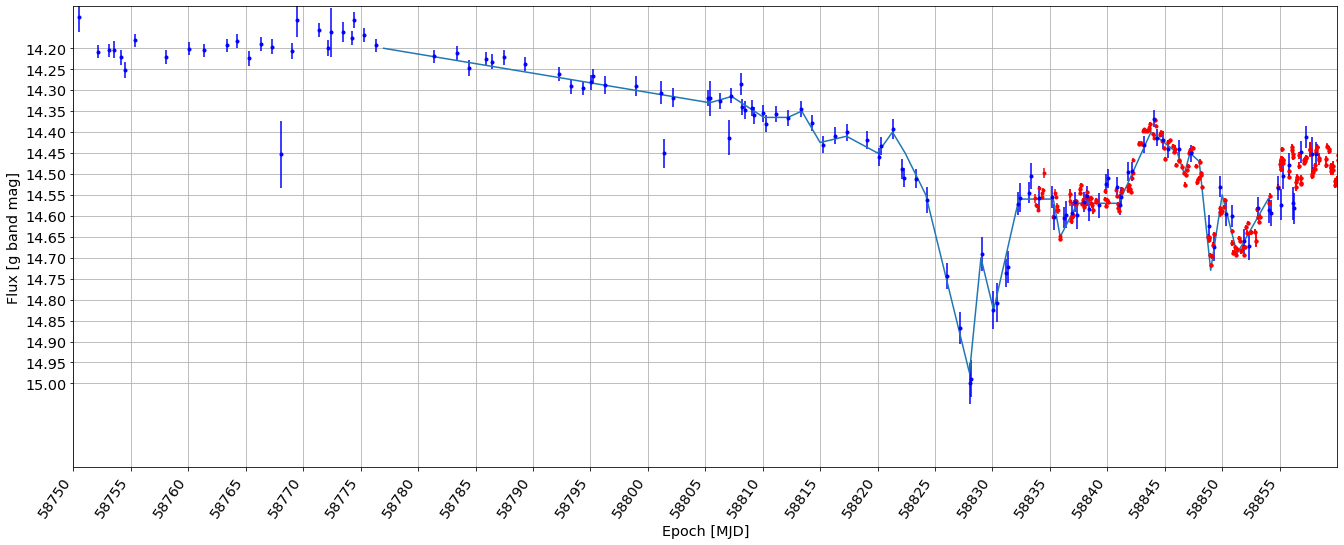

In [10]:
%matplotlib inline

fig, axes = plt.subplots(1, 1, figsize=(26, 8)) # , sharey=True)
axes.errorbar(tlco['MJD'],tlco['gmag']+13.01, yerr=tlco['gmag_err'], fmt='.',color='red', label="LCO g' (MAK and EG)")
axes.errorbar(tasp['MJD'], tasp['mag'], yerr=tasp['mag_err'], fmt='.', color='blue', label='ASAS-SN PSF sub')

axes.set_yticks(np.arange(14.2, 15.0, step=0.05))
axes.set_xticks(np.arange(58700, 58860, step=5))
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for tick in axes.get_xticklabels():
            tick.set_rotation(55)
            tick.set_ha('right')
            
c = ascii.read('g_band_straight_lines.txt')
axes.plot(c['MJD'],c['g'])
axes.set_xlim(58750,58860)

axes.set_ylim(15.2,14.1)
plt.ylabel('Flux [g band mag]')
plt.xlabel('Epoch [MJD]')
plt.grid()
plt.savefig('grid_g_curve.pdf')

In [11]:
c['lum'] = np.power(10,-(c['g']-14.2)/2.5)

Text(0, 0.5, 'Transmission')

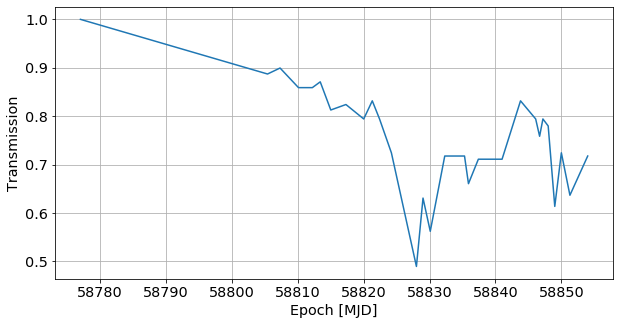

In [12]:
fig = plt.figure(figsize=(10,5))

plt.plot(c['MJD'],c['lum'])
plt.grid()
plt.xlabel('Epoch [MJD]')
plt.ylabel('Transmission')

Text(0.5, 1, 'Measured light curve gradients in J0600')

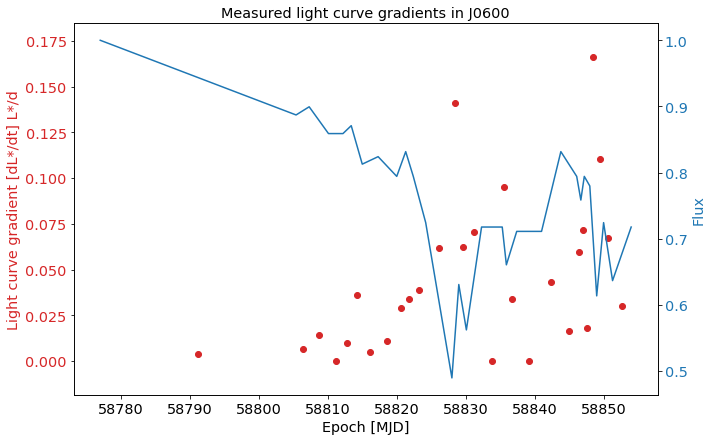

In [13]:
dl = c['lum'][:-1]-c['lum'][1:]
dt = c['MJD'][:-1]-c['MJD'][1:]

tmid1 = c['MJD'][:-1]
tmid2 = c['MJD'][1:]
tm = (tmid1+tmid2)/2.

grad = np.abs(dl/dt)

fig, ax1 = plt.subplots(figsize=(10,6))


color = 'tab:red'
ax1.set_xlabel('Epoch [MJD]')
ax1.set_ylabel('Light curve gradient [dL*/dt] L*/d', color=color)
#ax1.plot(t, data1, color=color)
ax1.scatter(tm, grad, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Flux', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.plot(c['MJD'],c['lum'],color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Measured light curve gradients in J0600')